In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

import explore

## Data Exploration

The dataset consists of 7 different csv's detailing play-by-play data for the 2021-2022 NBA season, statistics covering the season, and additional data about every shot attempted during the season.

The initial dataset has 181 features and 1_958_750 observations

In [2]:
nbastats, nbapo, nbadata, nbastats_po, pbpstats, shotdetail, shotdetail_po = explore.import_nba()

### DATA SNAPSHOT

In [3]:
nbastats.head(2)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,22200001,2,12,0,1,7:36 PM,12:00,NaN,Start of 1st Period (7:36 PM EST),NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0
1,22200001,4,10,0,1,7:36 PM,12:00,Jump Ball Horford vs. Embiid: Tip to Harris,NaN,NaN,...,76ers,PHI,5,202699,Tobias Harris,1.610613e+09,Philadelphia,76ers,PHI,1


In [4]:
nbapo.head(2)

,evt,wallclk,cl,de,locX,locY,opt1,opt2,opt3,opt4,...,tid,pid,hs,vs,epid,oftid,ord,pts,PERIOD,GAME_ID
0,2,2023-04-16T21:51:03.100Z,12:00,Start Period,0,-80,0,0,0,0,...,0,0,0,0,NaN,0,20000,0,1,42200101
1,4,2023-04-16T21:51:06.600Z,11:56,Jump Ball Adebayo vs Lopez (Butler gains posse...,0,-80,0,0,0,0,...,1610612748,1628389,0,0,202710.0,1610612748,60000,0,1,42200101


In [5]:
nbadata.head(2)

,evt,wallclk,cl,de,locX,locY,opt1,opt2,opt3,opt4,...,tid,pid,hs,vs,epid,oftid,ord,pts,PERIOD,GAME_ID
0,2,2022-10-18T23:35:25.400Z,12:00,Start Period,0,-80,0,0,0,0,...,0,0,0,0,NaN,0,20000,0,1,22200001
1,4,2022-10-18T23:35:27.800Z,11:57,Jump Ball Embiid vs Horford (Harris gains poss...,0,-80,0,0,0,0,...,1610612755,203954,0,0,202699.0,1610612755,60000,0,1,22200001


In [6]:
shotdetail.head(2)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,22200005,7,1627749,Dejounte Murray,1610612737,Atlanta Hawks,1,11,44,...,Right Side Center(RC),16-24 ft.,18,77,172,1,1,20221019,ATL,HOU
1,Shot Chart Detail,22200005,10,1629027,Trae Young,1610612737,Atlanta Hawks,1,11,14,...,Center(C),24+ ft.,36,1,363,1,0,20221019,ATL,HOU


## Which features to keep?

My final dataframes when full prepared will be three dimensional consisting of shape[N, T, F]. 

N = number of teams. The Mvp only consisted of teams that I will be testing on. The play off teams.

T = Time steps. Each oberservation from the dataframes are one game.

F = Features will only be focused on scores and defensive stats. As well as a decaying wight scheme to capture recency bias. 

Each test will be in the next sequence. The model will try all teh games in the past, and the last 5 to ten games. As well as their last games. 

In [7]:
team = explore.mvp_team()

In [8]:
team.head(30)

,visitor,home,hs,vs,result,hlast,vlast,home_last5,visitor_last5
game_id,,,,,,,,,
22200001,1610612755,1610612738,126,117,1,0,0,0,0
22200002,1610612747,1610612744,123,109,1,0,0,0,0
22200003,1610612753,1610612765,113,109,1,0,0,0,0
22200004,1610612764,1610612754,107,114,0,0,0,0,0
22200005,1610612745,1610612737,117,107,1,0,0,0,0
22200006,1610612740,1610612751,108,130,0,0,0,0,0
22200007,1610612741,1610612748,108,116,0,0,0,0,0
22200008,1610612739,1610612761,108,105,1,0,0,0,0
22200009,1610612752,1610612763,115,112,1,0,0,0,0


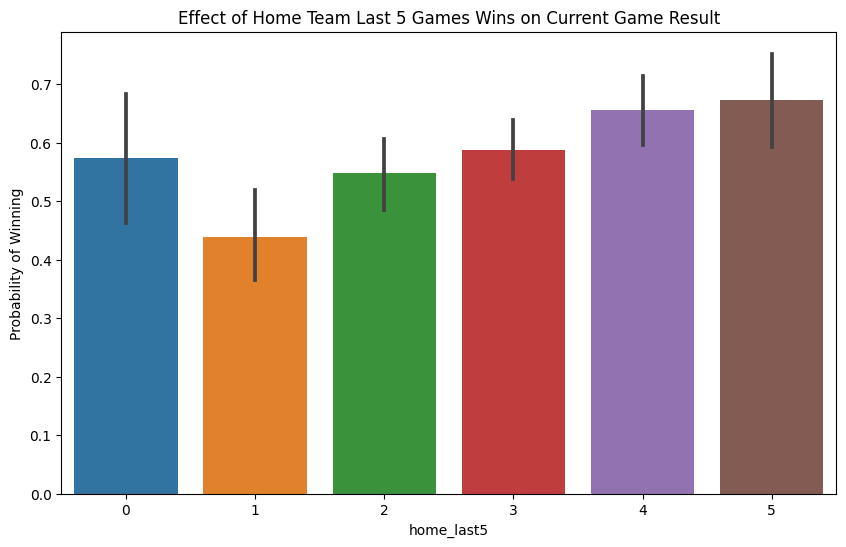

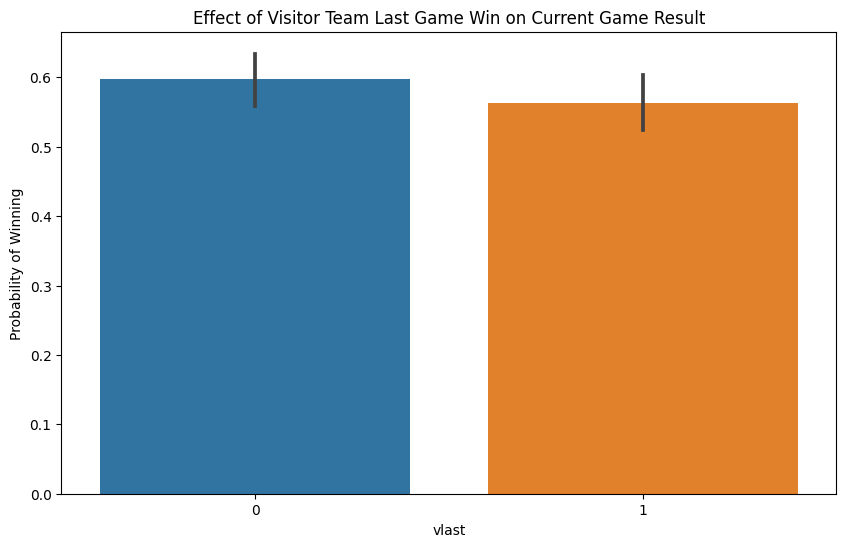

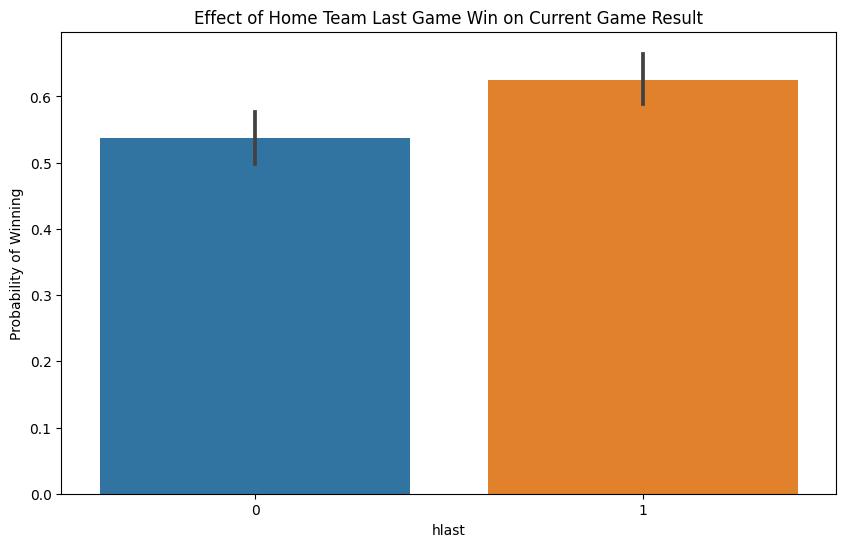

In [9]:
# Dataframe assuming you named it as 'team'
df = team

# Effect of home_last5 on winning or losing
plt.figure(figsize=(10, 6))
sns.barplot(x='home_last5', y='result', data=df)
plt.title('Effect of Home Team Last 5 Games Wins on Current Game Result')
plt.ylabel('Probability of Winning')
plt.show()

# Effect of vlast on winning or losing
plt.figure(figsize=(10, 6))
sns.barplot(x='vlast', y='result', data=df)
plt.title('Effect of Visitor Team Last Game Win on Current Game Result')
plt.ylabel('Probability of Winning')
plt.show()

# Effect of hlast on winning or losing
plt.figure(figsize=(10, 6))
sns.barplot(x='hlast', y='result', data=df)
plt.title('Effect of Home Team Last Game Win on Current Game Result')
plt.ylabel('Probability of Winning')
plt.show()

### Chart Takeaways

- Team was less likely to win if they had not won their precious game as compared to t

### Features of final dataframes

team_id
home or away
opponent_id
record total
record 
total points scored in the event
wins over last 5
wins over last game
wins over last 10


##### offensive stats
points
points first quarter
points second quarter
points third quarter
field goal percentage
field goal pts
three point pts
three point percentage
shooting fouls drawn
free throws
free throw percentage
assists


##### defensive stats
blocks 
steals 
turnovers 
rebounds
personal fouls




### Dimensionality

Very important to haggle over features becaue it was the primary method I had for reducing dimesionality.

If I had more computational power I would just run it as is and let the LSTM model determine it's own feature importance for later.

Running first test and depending on how many hyper perameters i want to change I will run Granger Causality and Cross-Correlation tests to see if I can reduce some of the features that are related over different time lags. This should be specifially relevant to the LSTM model.

## Random Forest Classificatoin Model

In [10]:
# 1. Data Preparation
X = team.drop(columns=['result', 'hs', 'vs'])  # Excluding 'hs' and 'vs' columns
y = team['result']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Model Training
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

# 3. Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)


Model Accuracy: 54.47%

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.31      0.38       108
           1       0.57      0.72      0.64       138

    accuracy                           0.54       246
   macro avg       0.52      0.52      0.51       246
weighted avg       0.53      0.54      0.53       246



### Model take away

- Model perfomred better than random guessing but there are not enough features to take advantage of the random forests strength. This daat structure is moer suited to deep learnign models.

## Baseline
As a baseline I am assuming that the team with the better winning rate over the season will win the first series of the season with a clean sweep, the first four games won.

I am not taking into account play in's or last games won for the test data.

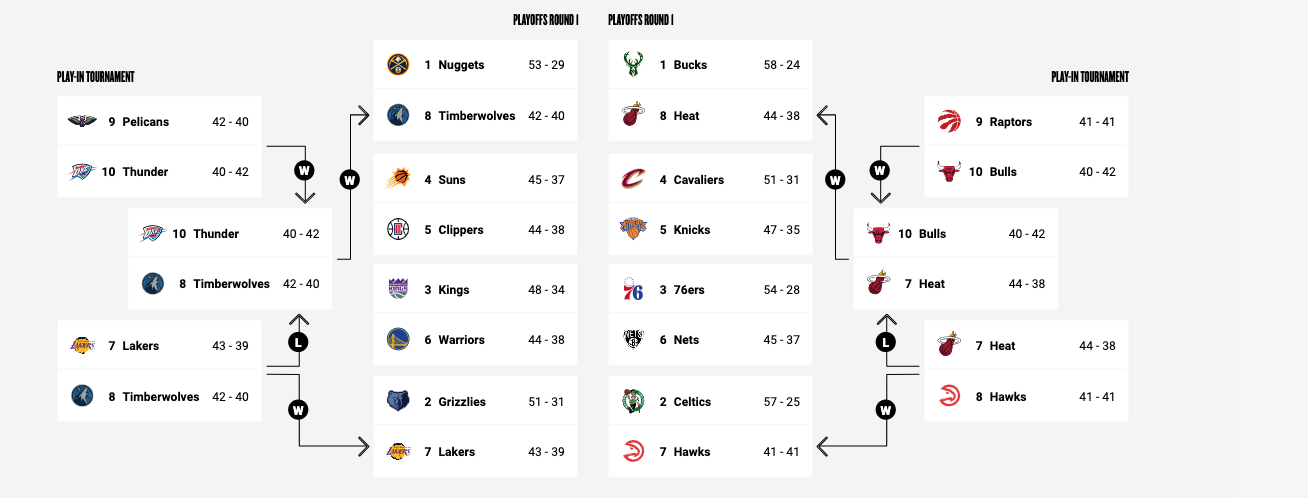

In [11]:
Image(filename="Play in and Play off Bracket 'nba.com'.png")

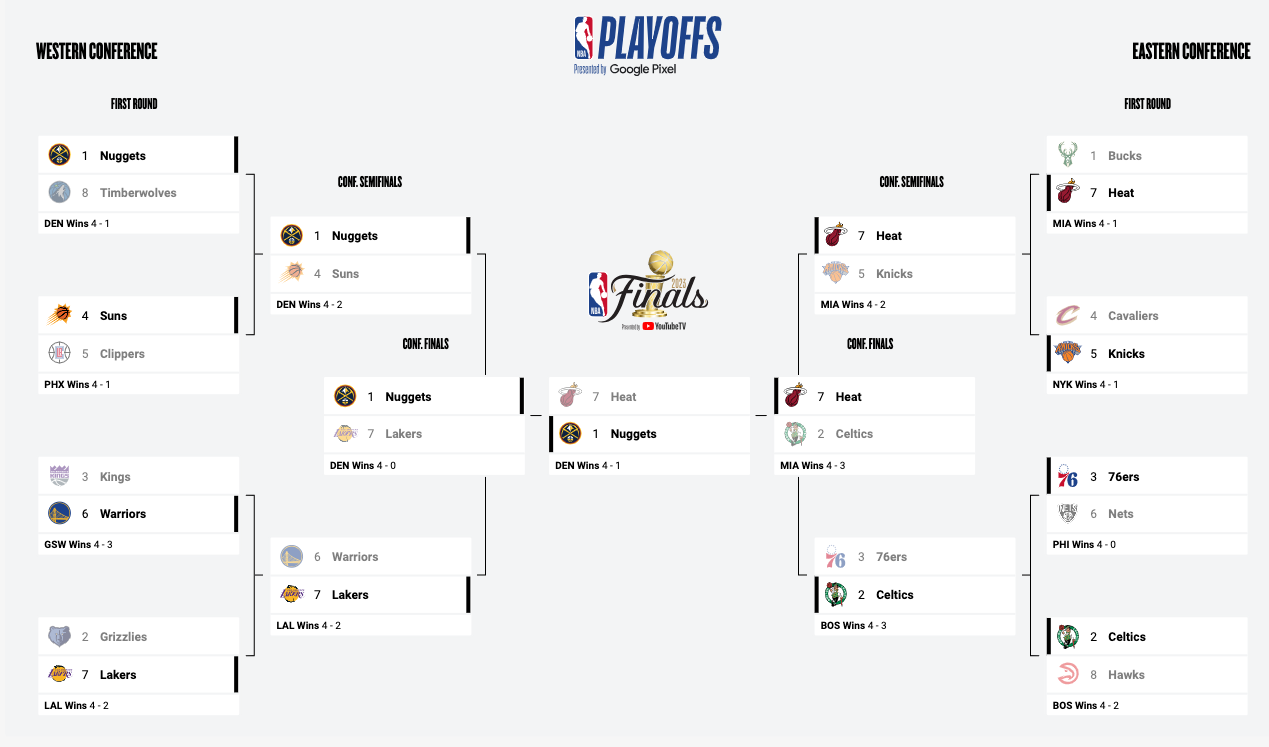

In [12]:
Image(filename="2023 nba finals braket 'nba.com'.png")

## Conclusion

The random Forest Model had an accuracy of 54%

How well did my model predict upsets? 
- My model only barely beat a coinflip.

How did my model do against the baseline?
- My model did beat the random flip baseline.

Evaluation
- As this is not the final model but this is the latest data I opted ot not run my model on test. This model will be used to inform future iterations and influenece feature selection.

## Continuaiton

#### For the deep learnign model
- Focus more on a decaying weight scheme
- Recency bias
- Treat deay rate as a hyperperameter through the differnet iterations

#### I woudl  like to have for features
Starting 5
- number of points
- complete prodution broken down by player
Bench players
- complete stats 
Height of starting 5
- this would be a good place to compare teams that score from range or in post

Incorporate not shot location data for a defensive stat.
- if a teams points come from a certain lane or their clutch points come from certain players that could be a good metric to have when determining the winner of close games.

Having the play by play and minute by minute data incorpotad.
The data is avabilable just currently not feasable with the resources and time available for this project 

Would like to play more with the decaying weight scheme. You can use it as a hyper perameter because of how much control you have but due to processesing power restraints I could not run multiple schemes to determine the most predictive weighing algorithm. 